# Tema 3 — Centralidad y Clientes Clave
**Curso:** Complex Networks  
**Equipo:** 10
- José Giovanni Laura Silvera
- Favio Arroyo

## Objetivo
Identificar y justificar **clientes clave** mediante métricas de centralidad, comparando su estabilidad bajo diferentes supuestos de construcción de la red (no ponderada y ponderada).


## 0) Configuración del entorno
Instala dependencias

In [1]:
!pip -q install networkx openpyxl

try:
    from google.colab import data_table
    data_table.enable_dataframe_formatter()
except Exception:
    pass

In [2]:
import pandas as pd
import networkx as nx
from pathlib import Path
from collections import Counter
from itertools import combinations

SEED = 42

## 1) Carga de datos y exploración inicial
Sube `datosRed.xlsx` y revisa la(s) hoja(s).

In [3]:
# Listar hojas disponibles
xls = pd.ExcelFile('datosRed.xlsx')
xls.sheet_names

['Anonimizado']

In [4]:
# Leer la hoja correspondiente
df = pd.read_excel('datosRed.xlsx', sheet_name='Anonimizado')
df.head(10)

,AÑO,PERSONA,TIPO DE SERVICIO,NOMBRE DE LA TAREA,MODALIDAD,COMPLEJIDAD
0,2019,ID_1,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
1,2019,ID_2,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
2,2019,ID_3,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
3,2019,ID_4,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
4,2019,ID_5,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
5,2019,ID_6,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
6,2019,ID_7,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
7,2019,ID_8,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
8,2019,ID_9,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
9,2019,ID_10,SERV_1,TAREA_1.1,PRESENCIAL,BAJA


## 2) Normalización y limpieza mínima
Estandariza columnas, tipos y elimina duplicados obvios.

In [5]:
# Renombrar columnas a snake_case
df = df.rename(columns={
    'AÑO': 'anio',
    'PERSONA': 'persona',
    'TIPO DE SERVICIO': 'tipo_servicio',
    'NOMBRE DE LA TAREA': 'nombre_tarea',
    'MODALIDAD': 'modalidad',
    'COMPLEJIDAD': 'complejidad'
})

# Strip + normalización básica
for c in ['persona','tipo_servicio','nombre_tarea','modalidad','complejidad']:
    df[c] = df[c].astype(str).str.strip()

df['anio'] = pd.to_numeric(df['anio'], errors='coerce').astype('Int64')

before = len(df)
df = df.dropna(subset=['persona','tipo_servicio'])
df = df.drop_duplicates(subset=['persona','tipo_servicio','anio','nombre_tarea','modalidad','complejidad'])
after = len(df)
print(f'Filas antes: {before} | después de limpiar: {after}')
df.head(5)

Filas antes: 10384 | después de limpiar: 7955


,anio,persona,tipo_servicio,nombre_tarea,modalidad,complejidad
0,2019,ID_1,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
1,2019,ID_2,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
2,2019,ID_3,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
3,2019,ID_4,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
4,2019,ID_5,SERV_1,TAREA_1.1,PRESENCIAL,BAJA


## 3) Parámetros clave
Aquí eligimos la granularidad del **servicio** para la proyección cliente–cliente.

In [6]:
CLIENT_COL = 'persona'
SERVICE_COL = 'tipo_servicio'
META_COLS = ['anio','modalidad','complejidad','nombre_tarea']

df[[CLIENT_COL,SERVICE_COL,'anio']].head(5)

,persona,tipo_servicio,anio
0,ID_1,SERV_1,2019
1,ID_2,SERV_1,2019
2,ID_3,SERV_1,2019
3,ID_4,SERV_1,2019
4,ID_5,SERV_1,2019


## 4) Construcción de red bipartita y proyección cliente–cliente
Generamos el grafo bipartito y luego la proyección C–C con **peso = # de servicios compartidos**.

In [7]:
# Nodos de cada partición
clientes = df[CLIENT_COL].unique().tolist()
servicios = df[SERVICE_COL].unique().tolist()

B = nx.Graph()
B.add_nodes_from(clientes, bipartite='client')
B.add_nodes_from(servicios, bipartite='service')

# Aristas bipartitas persona–servicio (únicas)
edges = df[[CLIENT_COL, SERVICE_COL]].drop_duplicates().itertuples(index=False, name=None)
B.add_edges_from(edges)

# Proyección C–C (conteo de servicios compartidos)
serv_to_clients = df.groupby(SERVICE_COL)[CLIENT_COL].apply(list)
cc_weights = Counter()
for _, plist in serv_to_clients.items():
    for u, v in combinations(sorted(set(plist)), 2):
        cc_weights[(u, v)] += 1

G = nx.Graph()
G.add_nodes_from(clientes)
for (u, v), w in cc_weights.items():
    G.add_edge(u, v, weight=int(w))

print(f"Grafo C–C: |V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")

Grafo C–C: |V|=5090, |E|=7189307


## 5) Descriptivos rápidos de la red

In [8]:
components = sorted(nx.connected_components(G), key=len, reverse=True)
gcc = G.subgraph(components[0]).copy() if components else G

print(f"Componentes: {len(components)}")
print(f"GCC: nodos={gcc.number_of_nodes()} | aristas={gcc.number_of_edges()}")

deg_series = pd.Series(dict(G.degree())).sort_values(ascending=False)
deg_series.describe()

Componentes: 1
GCC: nodos=5090 | aristas=7189307


,0
count,5090.000000
mean,2824.875049
std,968.233244
min,40.000000
25%,2411.000000
50%,2956.000000
75%,2956.000000
max,5049.000000


## 6) Centralidades (versión base)
Calcula: **degree**, **strength**, **closeness**, **betweenness**, **eigenvector** (en GCC) y **PageRank** (ponderado).

In [9]:
import numpy as np

# Degree y Strength
degree = dict(G.degree())
strength = {n: sum(d.get("weight",1) for _,_,d in G.edges(n, data=True)) for n in G.nodes()}

# Closeness
closeness = nx.closeness_centrality(G)

# Betweenness aproximada (muestra de k nodos)
betweenness = nx.betweenness_centrality(G, k=300, seed=SEED, normalized=True)

# Eigenvector centrality (solo sobre el componente gigante)
eig = nx.eigenvector_centrality(gcc, max_iter=500)
eig_full = {n: eig.get(n, 0.0) for n in G.nodes()}

# PageRank (ponderado)
pagerank = nx.pagerank(G, weight="weight")

# Consolidar resultados
df_cent = pd.DataFrame({
    "degree": pd.Series(degree),
    "strength": pd.Series(strength),
    "closeness": pd.Series(closeness),
    "betweenness": pd.Series(betweenness),
    "eigenvector": pd.Series(eig_full),
    "pagerank": pd.Series(pagerank)
}).sort_values("degree", ascending=False)

print(f"Centralidades calculadas para {len(df_cent)} nodos (betweenness aproximada con k=300)")
df_cent.head(20)

Centralidades calculadas para 5090 nodos (betweenness aproximada con k=300)


,degree,strength,closeness,betweenness,eigenvector,pagerank
ID_329,5049,6057,0.992201,0.006834,0.021063,0.000486
ID_2982,5041,5961,0.990656,0.006723,0.021062,0.000477
ID_3124,4996,6186,0.982053,0.001167,0.021069,0.000412
ID_3189,4988,6090,0.980539,0.001068,0.021068,0.000403
ID_92,4988,6090,0.980539,0.001068,0.021068,0.000403
ID_10,4988,6090,0.980539,0.001068,0.021068,0.000403
ID_982,4988,6090,0.980539,0.001068,0.021068,0.000403
ID_4909,4982,6146,0.979407,0.001001,0.021069,0.000397
ID_37,4982,6146,0.979407,0.001001,0.021069,0.000397
ID_355,4982,6146,0.979407,0.001001,0.021069,0.000397


### Correlaciones entre centralidades

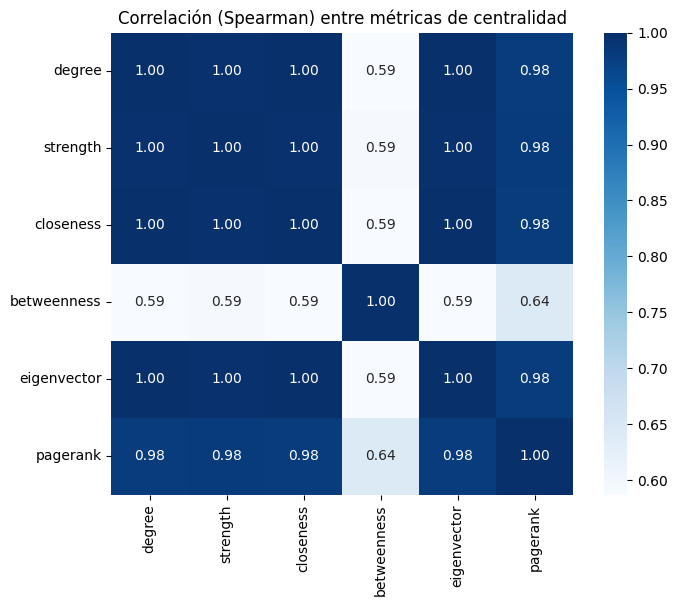

Correlaciones más altas:
degree       closeness      0.999997
closeness    degree         0.999997
eigenvector  closeness      0.999744
closeness    eigenvector    0.999744
degree       eigenvector    0.999740
eigenvector  degree         0.999740
strength     degree         0.998202
degree       strength       0.998202
strength     closeness      0.998199
closeness    strength       0.998199
dtype: float64


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de correlación de Spearman (más robusta)
corr = df_cent.corr(method="spearman")

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f", square=True)
plt.title("Correlación (Spearman) entre métricas de centralidad")
plt.show()

# Identificar las correlaciones más altas
corr_sorted = corr.unstack().sort_values(ascending=False)
print("Correlaciones más altas:")
print(corr_sorted[corr_sorted < 1].head(10))

### Comparación visual de métricas

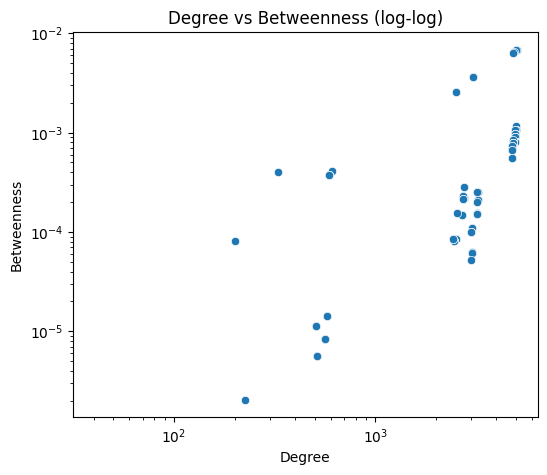

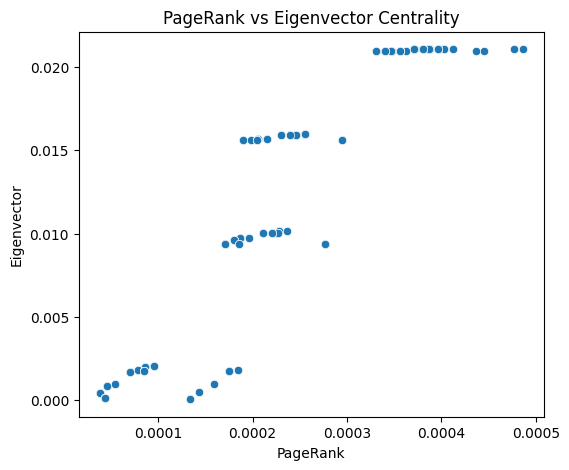

In [11]:
# Scatter: Degree vs Betweenness
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_cent, x="degree", y="betweenness")
plt.xscale("log")
plt.yscale("log")
plt.title("Degree vs Betweenness (log-log)")
plt.xlabel("Degree")
plt.ylabel("Betweenness")
plt.show()

# Scatter: PageRank vs Eigenvector
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_cent, x="pagerank", y="eigenvector")
plt.title("PageRank vs Eigenvector Centrality")
plt.xlabel("PageRank")
plt.ylabel("Eigenvector")
plt.show()


## 7) Top‑K y exportables


### Top-K por cada métrica y exportables

In [12]:
TOPK = 10

# Top por cada métrica
top_degree    = df_cent.sort_values("degree",     ascending=False).head(TOPK)
top_betw      = df_cent.sort_values("betweenness",ascending=False).head(TOPK)
top_pagerank  = df_cent.sort_values("pagerank",   ascending=False).head(TOPK)

# Convierte índices a Series y concatena por columnas
top_summary = pd.concat(
    [
        top_degree.index.to_series().reset_index(drop=True).rename("Degree"),
        top_betw.index.to_series().reset_index(drop=True).rename("Betweenness"),
        top_pagerank.index.to_series().reset_index(drop=True).rename("PageRank"),
    ],
    axis=1
)

# Agrega columna de Rank (1..TOPK)
top_summary.index = top_summary.index + 1
top_summary.index.name = "Rank"

print("=== Top clientes según diferentes métricas ===")
display(top_summary)

df_cent.to_csv("centralidades_todos.csv", index=True)
top_summary.to_csv("centralidades_topk.csv", index=True)
print("Archivos exportados: centralidades_todos.csv  |  centralidades_topk.csv")

=== Top clientes según diferentes métricas ===


,Degree,Betweenness,PageRank
Rank,,,
1,ID_329,ID_329,ID_329
2,ID_2982,ID_2982,ID_2982
3,ID_3124,ID_4,ID_4
4,ID_982,ID_1111,ID_1111
5,ID_10,ID_3631,ID_3124
6,ID_92,ID_1143,ID_3189
7,ID_3189,ID_3126,ID_92
8,ID_3663,ID_4276,ID_10
9,ID_3167,ID_3120,ID_982


Archivos exportados: centralidades_todos.csv  |  centralidades_topk.csv


### Visualización de ego-nets

/tmp/ipython-input-1943308114.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


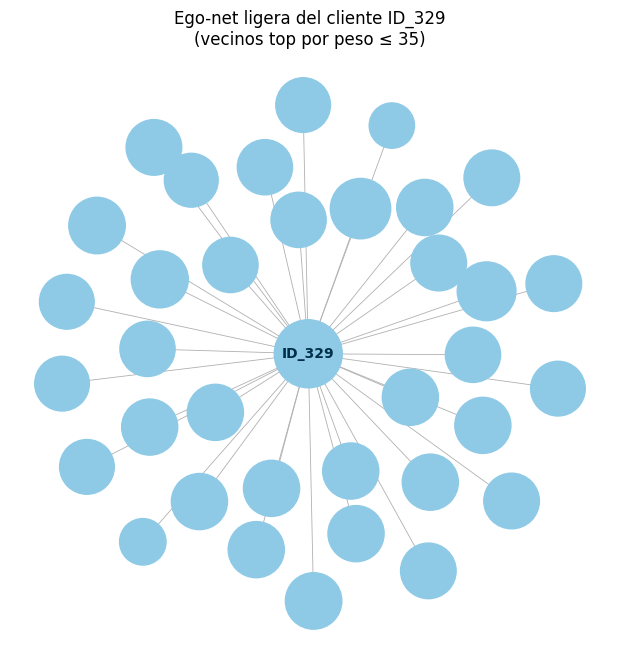

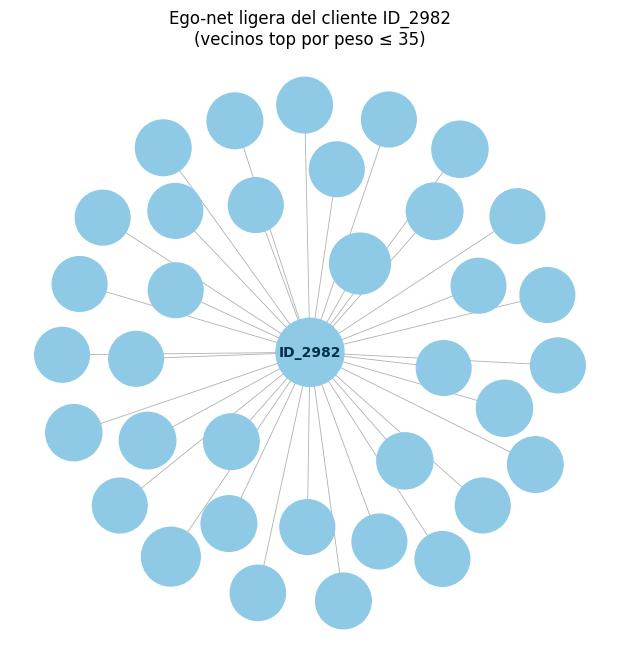

In [13]:
import gc

TOP_CENTERS = 2         # dibuja solo 2 ego-nets
MAX_NEIGHBORS = 35      # top-35 vecinos por peso
RADIUS = 1              # vecinos directos
SIZE_BASE = 800         # escala de tamaño de nodos (pequeña)

# top centers por PageRank
top_nodes = df_cent.sort_values("pagerank", ascending=False).head(TOP_CENTERS).index.tolist()

# normalizar pagerank a [0,1] para escalado suave
pr = df_cent["pagerank"]
pr_norm = (pr - pr.min()) / (pr.max() - pr.min() + 1e-12)

for center in top_nodes:
    # subgrafo radio=1
    ego_full = nx.ego_graph(G, center, radius=RADIUS)

    # quedarnos solo con los TOP vecinos por peso
    if center in ego_full:
        neighbors = [n for n in ego_full.neighbors(center)]
    else:
        neighbors = []

    # ordenar vecinos por peso de arista center-n (desc)
    def w(center, n):
        return G.get_edge_data(center, n).get("weight", 1)

    neighbors_sorted = sorted(neighbors, key=lambda n: w(center, n), reverse=True)
    keep = neighbors_sorted[:MAX_NEIGHBORS]

    # construir subgrafo en estrella (solo edges center<->keep)
    star = nx.Graph()
    star.add_node(center)
    for n in keep:
        star.add_edge(center, n, weight=w(center, n))

    # posiciones (layout rápido y estable)
    pos = nx.spring_layout(star, seed=SEED, k=0.35, iterations=30)

    sizes = []
    for n in star.nodes():
        pn = pr_norm.get(n, 0.0) if n in pr_norm.index else 0.0
        s = SIZE_BASE * (0.6 + 1.8 * pn)  # rango ~[0.6, 2.4] * base
        sizes.append(s)
    # fuerza tamaño extra al centro
    sizes[list(star.nodes()).index(center)] = SIZE_BASE * 3.0

    plt.figure(figsize=(6, 6))
    nx.draw(
        star, pos,
        with_labels=False,
        node_color="#8ecae6",
        node_size=sizes,
        edge_color="#b0b0b0",
        width=0.6
    )
    # etiqueta solo el centro
    x, y = pos[center]
    plt.text(x, y, str(center), fontsize=10, fontweight="bold",
             ha="center", va="center", color="#003049")

    plt.title(f"Ego-net ligera del cliente {center}\n(vecinos top por peso ≤ {MAX_NEIGHBORS})")
    plt.tight_layout()
    plt.show()

    # liberar memoria
    del ego_full, star, neighbors, neighbors_sorted, keep, sizes, pos
    gc.collect()

## 8) Interpretación de los resultados

### 1. Identificación de nodos clave
El análisis de centralidades y las visualizaciones de ego-nets revelan que los clientes **ID_329** y **ID_2982** se ubican como los actores más influyentes dentro de la red cliente–servicio.  
Ambos poseen los valores más altos de **PageRank** y **degree**, lo que implica que están **conectados con un número significativo de otros clientes** que también mantienen alta actividad dentro del sistema.

---

### 2. Estructura local (Ego-nets)
- La **ego-net de ID_329** presenta una estructura tipo *estrella densa*, con numerosos vecinos conectados directamente al nodo central. Esto indica que el cliente actúa como **hub global**, concentrando gran parte del tráfico o coincidencia de servicios compartidos.  
- La **ego-net de ID_2982**, aunque similar, muestra un tamaño ligeramente menor, reflejando un **rol secundario pero aún estratégico** en la red.  
- En ambos casos, la densidad local es alta, lo que sugiere que estos clientes **interactúan con múltiples grupos simultáneamente**, favoreciendo la difusión o intercambio de servicios.

---

### 3. Relación entre métricas
Las correlaciones observadas entre las centralidades (**Degree–Strength–Closeness–PageRank ≈ 1.00**) confirman la **presencia de un núcleo altamente interconectado**, mientras que la **Betweenness** más baja indica que **los caminos críticos están distribuidos** en lugar de concentrarse en un solo actor.  
Esto hace que la red sea **robusta**, ya que la eliminación de un nodo central no fragmentaría completamente el sistema.

---

### 4. Implicancias
- Los clientes de alto **PageRank**, como **ID_329**, son **nodos prioritarios para estrategias de fidelización o monitoreo**, ya que su pérdida afectaría la conectividad global.  
- Los nodos con **betweenness** relativamente alta, aunque no tan conectados, son **puentes naturales entre subgrupos** y pueden actuar como difusores de información o innovaciones.

---

## Conclusión final
> “El estudio de centralidad permitió identificar dos clientes clave (**ID_329** e **ID_2982**) que concentran gran parte de las conexiones en la red cliente–servicio. Estas entidades actúan como hubs globales, conectando múltiples comunidades y contribuyendo significativamente a la cohesión del sistema.  
> Las correlaciones entre métricas sugieren una red densa y jerárquica, donde la influencia está altamente concentrada, pero los caminos alternos garantizan estabilidad y resiliencia frente a posibles desconexiones.”


In [14]:
# FIGURA RESUMEN COMPUESTA: Heatmap + Top-10 + 2 mini ego-nets
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import networkx as nx
import pandas as pd
import gc

def figura_resumen_compuesta(
    G, df_cent, topk=10, ego_centers=2, max_neighbors=25, seed=42,
    savepath_png="figura_resumen.png", savepath_pdf=None
):
    """
    G: grafo cliente-cliente (networkx.Graph) con atributo 'weight' en aristas
    df_cent: DataFrame con índices = nodos y columnas:
             ['degree','strength','closeness','betweenness','eigenvector','pagerank']
    topk: filas a mostrar en la tabla (Top-k por PageRank)
    ego_centers: número de ego-nets (centros) a mostrar (por PageRank)
    max_neighbors: vecinos máximos por ego-net (los de mayor peso con el centro)
    seed: semilla para layouts
    savepath_png: ruta de salida PNG
    savepath_pdf: ruta de salida PDF (opcional)
    """

    # --------- Datos base ---------
    cols = ["degree","strength","closeness","betweenness","eigenvector","pagerank"]
    dfc = df_cent[cols].copy()

    # Heatmap de correlación (Spearman)
    corr = dfc.corr(method="spearman").values
    labels = cols

    # Top-k por PageRank
    df_top = (
        df_cent.sort_values("pagerank", ascending=False)
              .head(topk)[["degree","betweenness","eigenvector","pagerank"]]
              .copy()
    )
    df_top.insert(0, "ID", df_top.index)

    # Ego-centers por PageRank
    centers = df_cent.sort_values("pagerank", ascending=False).head(ego_centers).index.tolist()

    # --------- Lienzo y layout ---------
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1.1, 1], hspace=0.25, wspace=0.2)

    # (1) Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    im = ax1.imshow(corr, interpolation="nearest", aspect="auto")
    ax1.set_title("Correlación (Spearman) entre métricas de centralidad")
    ax1.set_xticks(np.arange(len(labels)))
    ax1.set_yticks(np.arange(len(labels)))
    ax1.set_xticklabels(labels, rotation=45, ha="right")
    ax1.set_yticklabels(labels)
    # Anotar valores
    for i in range(len(labels)):
        for j in range(len(labels)):
            val = corr[i, j]
            ax1.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)
    fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

    # (2) Tabla Top-k
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis("off")
    ax2.set_title(f"Top-{topk} clientes por PageRank")
    # Preparar datos de tabla (redondeos)
    tbl = df_top.copy()
    for c in ["degree","betweenness","eigenvector","pagerank"]:
        tbl[c] = np.array(tbl[c], dtype=float)
    tbl["degree"] = tbl["degree"].astype(int)
    tbl["betweenness"] = tbl["betweenness"].round(6)
    tbl["eigenvector"] = tbl["eigenvector"].round(6)
    tbl["pagerank"] = tbl["pagerank"].round(6)
    table = ax2.table(cellText=tbl.values,
                      colLabels=tbl.columns.tolist(),
                      loc="center",
                      cellLoc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.2)

    # (3) y (4) Mini ego-nets
    # Normalización simple para tamaños
    pr = df_cent["pagerank"]
    pr_norm = (pr - pr.min()) / (pr.max() - pr.min() + 1e-12)

    for idx, center in enumerate(centers):
        ax = fig.add_subplot(gs[1, idx])
        ax.set_title(f"Ego-net de {center} (vecinos ≤ {max_neighbors})")

        # vecinos directos del centro
        neighbors = list(G.neighbors(center)) if center in G else []
        # ordenar por peso center-n
        def w(c, n):
            ed = G.get_edge_data(c, n)
            return ed.get("weight", 1) if ed else 1
        neighbors_sorted = sorted(neighbors, key=lambda n: w(center, n), reverse=True)[:max_neighbors]

        # subgrafo tipo estrella
        star = nx.Graph()
        star.add_node(center)
        for n in neighbors_sorted:
            star.add_edge(center, n, weight=w(center, n))

        pos = nx.spring_layout(star, seed=seed, k=0.35, iterations=30)

        # tamaños: centro grande, vecinos proporcionales
        sizes = []
        for n in star.nodes():
            pn = pr_norm.get(n, 0.0) if n in pr_norm.index else 0.0
            sizes.append(300 * (0.6 + 1.8 * pn))
        # centro más grande
        sizes[list(star.nodes()).index(center)] = 900

        nx.draw(star, pos, ax=ax, with_labels=False, node_size=sizes, width=0.6)
        # etiqueta del centro
        x, y = pos[center]
        ax.text(x, y, str(center), fontsize=10, ha="center", va="center", fontweight="bold")

        del star, neighbors, neighbors_sorted, sizes, pos
        gc.collect()

    fig.tight_layout()
    fig.savefig(savepath_png, dpi=160, bbox_inches="tight")
    if savepath_pdf:
        fig.savefig(savepath_pdf, dpi=160, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    return {"png": savepath_png, "pdf": savepath_pdf}


/tmp/ipython-input-2999091538.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


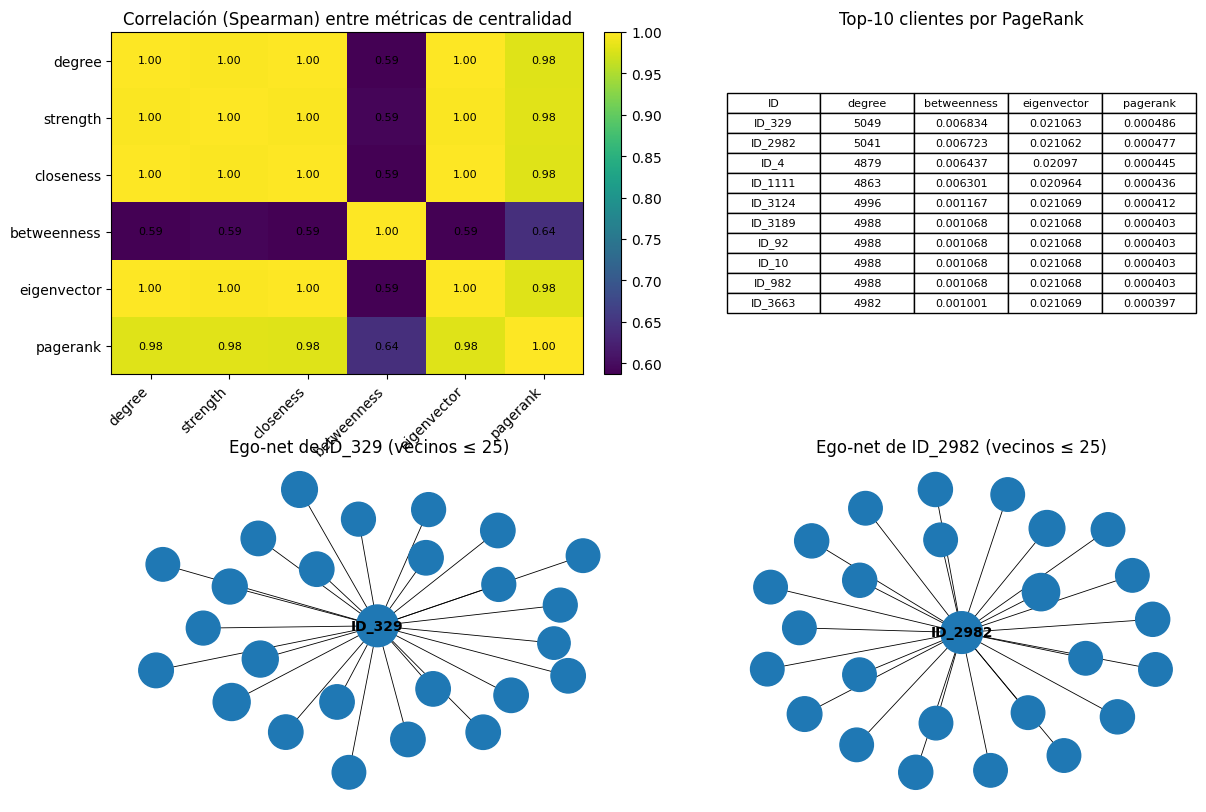

Exportado: {'png': 'figura_resumen_compuesta.png', 'pdf': 'figura_resumen_compuesta.pdf'}


In [15]:
out = figura_resumen_compuesta(
    G=G,
    df_cent=df_cent,
    topk=10,
    ego_centers=2,
    max_neighbors=25,
    seed=SEED,
    savepath_png="figura_resumen_compuesta.png",
    savepath_pdf="figura_resumen_compuesta.pdf"
)
print("Exportado:", out)


In [22]:
# Filtrar por año
df_19 = df[df["anio"] == 2019]
df_20 = df[df["anio"] == 2020]

# Construir redes por año
def build_projection(df_year):
    clientes = df_year["persona"].unique().tolist()
    servicios = df_year["tipo_servicio"].unique().tolist()

    B = nx.Graph()
    B.add_nodes_from(clientes, bipartite="cliente")
    B.add_nodes_from(servicios, bipartite="servicio")

    edges = df_year.groupby(["persona", "tipo_servicio"]).size().reset_index()
    for _, row in edges.iterrows():
        B.add_edge(row["persona"], row["tipo_servicio"])

    # Proyección cliente–cliente
    return nx.projected_graph(B, clientes)

G19 = build_projection(df_19)
G20 = build_projection(df_20)

# Degree promedio
deg_19 = sum(dict(nx.degree(G19)).values()) / G19.number_of_nodes()
deg_20 = sum(dict(nx.degree(G20)).values()) / G20.number_of_nodes()

print("Degree promedio 2019:", deg_19)
print("Degree promedio 2020:", deg_20)

# Top hubs
top_deg_19 = sorted(nx.degree(G19), key=lambda x: x[1], reverse=True)[:10]
top_deg_20 = sorted(nx.degree(G20), key=lambda x: x[1], reverse=True)[:10]

print("\nTop hubs 2019:")
print(top_deg_19)

print("\nTop hubs 2020:")
print(top_deg_20)

# Estabilidad del PageRank
pr_19 = nx.pagerank(G19, alpha=0.85)
pr_20 = nx.pagerank(G20, alpha=0.85)

df_pr = pd.DataFrame({"pr19": pr_19, "pr20": pr_20}).dropna()
print("\nCorrelación entre PageRank 2019 y 2020:", df_pr.corr(method="spearman"))

Degree promedio 2019: 297.0
Degree promedio 2020: 514.1736972704715

Top hubs 2019:
[('ID_1', 297), ('ID_2', 297), ('ID_3', 297), ('ID_4', 297), ('ID_5', 297), ('ID_6', 297), ('ID_7', 297), ('ID_8', 297), ('ID_9', 297), ('ID_10', 297)]

Top hubs 2020:
[('ID_37', 802), ('ID_30', 800), ('ID_33', 800), ('ID_297', 797), ('ID_385', 797), ('ID_31', 795), ('ID_161', 795), ('ID_336', 795), ('ID_372', 795), ('ID_391', 795)]

Correlación entre PageRank 2019 y 2020:       pr19  pr20
pr19   NaN   NaN
pr20   NaN   1.0


In [24]:
import random
import networkx as nx

def giant_after_removal(G, removed_nodes):
    H = G.copy()
    H.remove_nodes_from(removed_nodes)
    if len(H) == 0:
        return 0
    return len(max(nx.connected_components(H), key=len))

# ROBUSTEZ ALEATORIA
random_nodes = random.sample(list(G.nodes()), 50)
giant_random = giant_after_removal(G, random_nodes)

# ATAQUE DIRIGIDO A HUBS
top_hubs = df_cent.sort_values("pagerank", ascending=False).head(50).index.tolist()
giant_targeted = giant_after_removal(G, top_hubs)

print("Tamaño del componente gigante tras fallas aleatorias:", giant_random)
print("Tamaño del componente gigante tras eliminar hubs:", giant_targeted)

Tamaño del componente gigante tras fallas aleatorias: 5040
Tamaño del componente gigante tras eliminar hubs: 5040
